In [ ]:
%pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 18.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
import numpy as np

In [ ]:
import requests

url = "https://www.dropbox.com/scl/fi/x2eh2yil56rgu5id1fwbm/cnn_data1.csv?rlkey=7bltxkitlwdnuirw08r2ysuv4&st=5z04ff8s&dl=1"
response = requests.get(url)

# Save the file locally
with open('cnn_data1.csv', 'wb') as file:
    file.write(response.content)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_data_hist(df):
    # Define figure size and layout for subplots
    fig, axs = plt.subplots(3, 5, figsize=(15, 15), dpi=80)

    # List of columns to plot histograms for
    columns = ['Activation Function', 'Total Activations', 'Total Parameters', 'Batch Size',
               'Total_Activations_Batch_Size', 'Conv2d Count','BatchNorm2d Count', 'Dropout Count',
               'AdaptiveAvgPool2d Count', 'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
               'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)', 'architecture']

    # Loop over the axes and columns to create histograms
    for ax, col in zip(axs.ravel(), columns):
        if pd.api.types.is_numeric_dtype(df[col]):
            ax.hist(df[col], bins=200)
            ax.set_xlabel(col)
            ax.set_ylabel('count')
        else:
            print(f"Skipping non-numeric column: {col}")

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()


0       39517
1       36831
2        6293
3        6475
4        2779
        ...  
8995    40123
8996    38637
8997    26097
8998    39617
8999     4321
Name: Max GPU Memory (MiB), Length: 9000, dtype: int64
#datapoints:  9000
0       39517
1       42000
2        6293
3        6475
4        2779
        ...  
8995    42000
8996    42000
8997    26097
8998    42000
8999     4321
Name: Max GPU Memory (MiB), Length: 9000, dtype: int64
#datapoints:  9000
Index(['Activation Function', 'Total Activations', 'Total Parameters',
       'Batch Size', 'Total_Activations_Batch_Size', 'Conv2d Count',
       'BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
       'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)',
       'architecture'],
      dtype='object')
Activation Function | max :  Tanh | min:  ELU
Total Activations | max :  5317481490 | min:  24514
Total Parameters | max :  32930

<Figure size 10000x800 with 0 Axes>

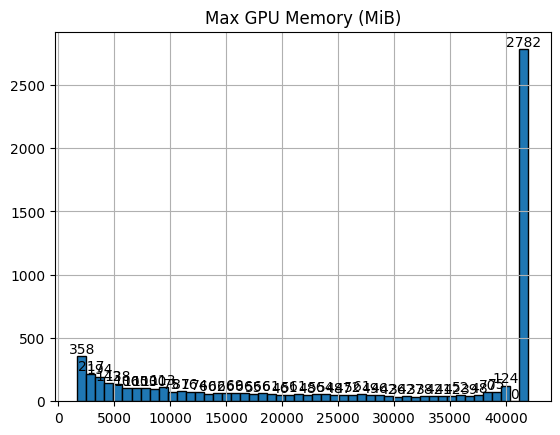

In [ ]:
csv_file_path = "cnn_data1.csv"  # Replace with the actual path to the produced CSV file

# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(csv_file_path)


print(df['Max GPU Memory (MiB)'])
print("#datapoints: ", len(df))
# print(df.columns)

df['Total_Activations_Batch_Size'] = df['Total Activations'] * df['Batch Size']

# training tasks crashed because of OOM, should be put aside (filter out)
# df = df.loc[df['Status'] != 'OOM_CRASH']

df.loc[df['Status'] == 'OOM_CRASH', 'Max GPU Memory (MiB)'] = 42000


print(df['Max GPU Memory (MiB)'])

print("#datapoints: ", len(df))


# dropping lines that they have NaN values as they will cause error in the next steps
# df = df.dropna()

df = df.dropna(subset=['Activation Function'])


# filtering out the architectures with dens and residual values
df = df[~df['architecture'].isin(['residual', 'dense'])]

# df = df[df['BatchNorm2d Count'] == 0]
# df = df[df['Dropout Count'] == 0]


df = df[['Activation Function', 'Total Activations', 'Total Parameters', 'Batch Size',
         'Total_Activations_Batch_Size', 'Conv2d Count','BatchNorm2d Count', 'Dropout Count',
         'AdaptiveAvgPool2d Count', 'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
         'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)', 'architecture']]

# print(df.columns)

# Map the existing columns to your desired column structure

# df = df.rename(columns={
#     'Max GPU Memory (MiB)': 'real_memory_usage',
#     'Conv2d Count': 'conv2d_layers',
#     'Activation Function': 'activation_function',
#     'Total_Activations_Batch_Size': 'total_activation_mul_batch_size',
#     'Batch Size': 'batch_size',
#     'Total Parameters': 'all_parameters',
#     'Total Activations': 'all_activations',
#     'Activations-Params': 'params_activation_list',
#     'BatchNorm2d Count': 'batch_norm2d_layer',
#     'Dropout Count': 'dropout_layers',
#     'Linear Count': 'linear_layers',
#     'AdaptiveAvgPool2d Count': 'adaptive_avg_pool2d_layers'
# })

print(df.columns)


columns_to_analyze = ['Activation Function', 'Total Activations', 'Total Parameters', 'Batch Size',
                      'Total_Activations_Batch_Size', 'Conv2d Count','BatchNorm2d Count', 'Dropout Count',
                      'AdaptiveAvgPool2d Count', 'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                      'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)']
for col in columns_to_analyze:
    if col == 'activation_function':
      continue
    print(f'{col} | max : ', df[col].max(), '| min: ', df[col].min())
print('len dataset: ', len(df))

# print(df.dtypes)


print("#datapoints: ", len(df))


# Plotting the histogram of 'Max GPU Memory (MiB)' with increased figure size and labeled bins
plt.figure(figsize=(100, 8))  # Increase the size of the figure
ax = df[['Max GPU Memory (MiB)']].hist(bins=50, edgecolor='black')

# Adding labels to the bins
for ax in plt.gcf().axes:
    for patch in ax.patches:
        # Get the coordinates and height of each bar (bin)
        height = patch.get_height()
        width = patch.get_width()
        # Calculate the position where the text will be displayed
        bin_center = patch.get_x() + width / 2
        # Display the height (number of items in each bin)
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

plt.show()

Skipping non-numeric column: Activation Function


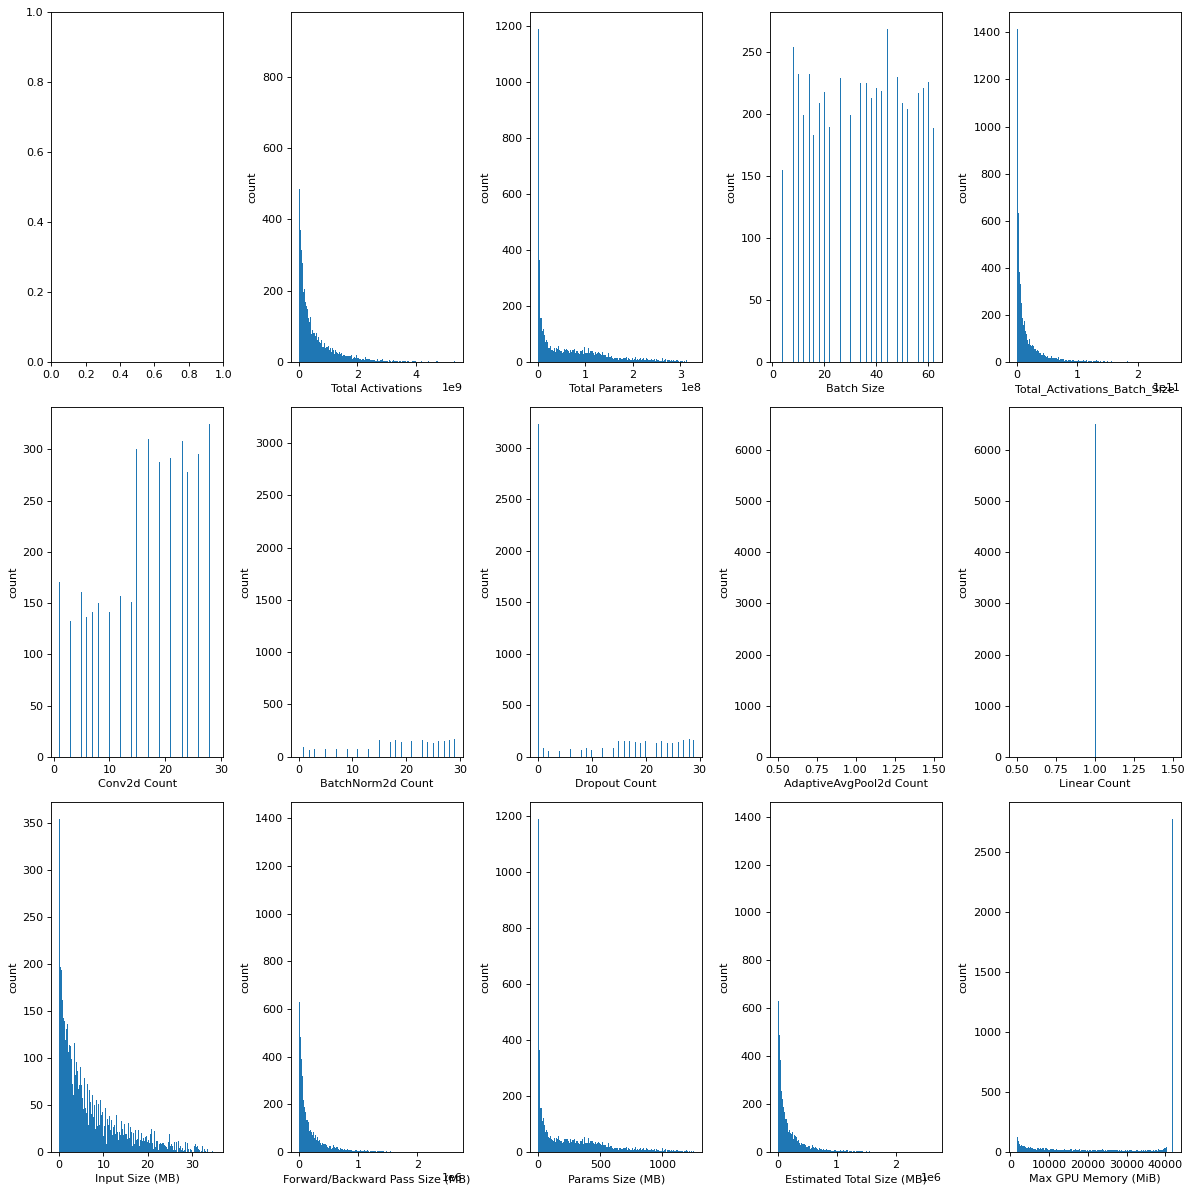

In [ ]:
plot_data_hist(df)

# having activations functions as two separate columns

In [ ]:
# List of activation functions
activations = ['ELU', 'GELU', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

# Function to create positional encoding
def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate positional encodings
positional_encodings = positional_encoding_2d(len(activations))
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Apply positional encoding to 'activation_function' column
df['activation_encoding_sin'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][0])
df['activation_encoding_cos'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][1])

print(df.columns)


Index(['Activation Function', 'Total Activations', 'Total Parameters',
       'Batch Size', 'Total_Activations_Batch_Size', 'Conv2d Count',
       'BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
       'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)',
       'architecture', 'activation_encoding_sin', 'activation_encoding_cos'],
      dtype='object')


In [ ]:
df

,Activation Function,Total Activations,Total Parameters,Batch Size,Total_Activations_Batch_Size,Conv2d Count,BatchNorm2d Count,Dropout Count,AdaptiveAvgPool2d Count,Linear Count,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),Max GPU Memory (MiB),architecture,activation_encoding_sin,activation_encoding_cos
0,GELU,195826172,1864805,62,12141222664,22,0,22,1,1,21.70,123506.48,7.11,123535.29,39517,uniform,0.309017,9.510565e-01
1,SELU,306385536,32924348,46,14093734656,11,11,11,1,1,2.30,134408.32,125.60,134536.22,42000,pyramid,0.951057,-3.090170e-01
2,ELU,27443119,1730036,34,933066046,14,0,0,1,1,3.06,10678.04,6.60,10687.70,6293,uniform,0.000000,1.000000e+00
3,ELU,119603463,731920,10,1196034630,16,16,16,1,1,2.90,11406.30,2.79,11411.99,6475,uniform,0.000000,1.000000e+00
4,ReLU,11111315,2960902,18,200003670,12,12,0,1,1,0.18,2034.54,11.29,2046.01,2779,gradual,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8994,Tanh,261412634,69541327,8,2091301072,19,19,19,1,1,0.64,19944.16,265.28,20210.08,12765,hourglass,0.309017,-9.510565e-01
8995,ELU,1224102531,174087245,14,17137435434,21,21,21,1,1,2.66,163435.30,664.09,164102.05,42000,hourglass,0.000000,1.000000e+00
8996,ELU,964897150,206115033,26,25087325900,21,0,21,1,1,4.68,255201.44,786.27,255992.39,42000,hourglass,0.000000,1.000000e+00
8997,PReLU,273489723,250091310,22,6016773906,29,0,29,1,1,0.88,61205.76,954.02,62160.66,26097,hourglass,0.951057,3.090170e-01


# filter the data


In [ ]:
# in case wanna filter some of the data use this code

# df_filtered = df[df['layers'] <= 64]
# df_filtered = df_filtered[df_filtered['all_parameters'] <= 10e6]
# df_filtered = df_filtered[df_filtered['batch_size'] <= 64]
# df_filtered = df_filtered[df_filtered['all_activations'] <= 1e5]
# print(len(df_filtered))
# plot_data_hist(df_filtered)


# classification

Index(['Total Activations', 'Total Parameters', 'Batch Size',
       'Total_Activations_Batch_Size', 'Conv2d Count', 'BatchNorm2d Count',
       'Dropout Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)'],
      dtype='object') 6516    Total Activations  Total Parameters  Batch Size  \
0          -0.481515         -0.863827    1.670786   
1          -0.312325         -0.433732    0.742251   
2          -0.739192         -0.865693    0.045850   
3          -0.598158         -0.879514   -1.346953   
4          -0.764184         -0.848649   -0.882685   

   Total_Activations_Batch_Size  Conv2d Count  BatchNorm2d Count  \
0                     -0.179003      0.558834          -0.855547   
1                     -0.102302     -0.818999           0.200458   
2                     -0.619294     -0.443226          -0.855547   
3                     -0.608964     -0.192711           0.680460   
4                     -0.648091    

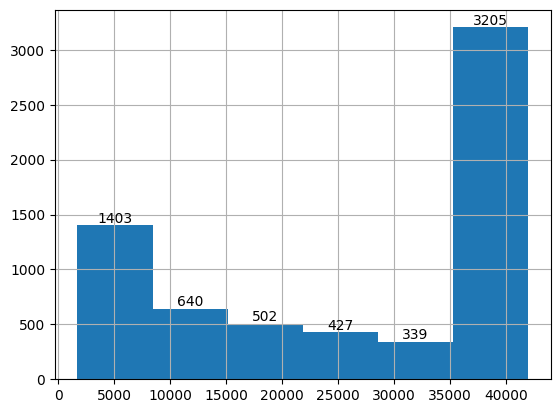

In [ ]:
columns_to_normalize = ['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']



from sklearn.preprocessing import StandardScaler
# # Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)

# no normalization
# df_normalized = df


print(df_normalized.columns, len(df_normalized), df_normalized.head())

print(df[["Activation Function"]])

print(df.columns)

df['Max GPU Memory (MiB)'].hist(bins=6)

# Adding labels to the bins
for ax in plt.gcf().axes:
    for patch in ax.patches:
        # Get the coordinates and height of each bar (bin)
        height = patch.get_height()
        width = patch.get_width()
        # Calculate the position where the text will be displayed
        bin_center = patch.get_x() + width / 2
        # Display the height (number of items in each bin)
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

plt.show()

# Hard Labeling

In [ ]:
import pandas as pd

# Define bins where values between 0-10000 fall into class 0, 10000-20000 into class 1, and so on
# bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, float('inf')]

# bins = [i*2000 for i in range(0, 23)]

# bins = [0, 8000, 16000, 24000, 32000, 40000, 50000, ]
bins = [0, 10000, 20000, 30000, 40000, 45000]

# Define labels corresponding to the bins
labels = [i for i in range(0, len(bins)-1)]


print(labels, len(labels), "\n", bins)

# Use pd.cut() to create a new column with labels based on the bins
df['memory_usage_label'] = pd.cut(df['Max GPU Memory (MiB)'], bins=bins, labels=labels, right=False)

# Display some rows where 'memory_usage_label' falls into the last bin (infinite)
inf_rows = df.loc[df['memory_usage_label'] == labels[2]]  # labels[-1] is the label for the last bin

print(inf_rows.tail())

[0, 1, 2, 3, 4, 5] 6 
 [0, 8000, 16000, 24000, 32000, 40000, 50000]
     Activation Function  Total Activations  Total Parameters  Batch Size  \
8958               PReLU           71779398         133571856          50   
8973               PReLU          103739303           4559756          60   
8974                ReLU           77787688         112012559          46   
8979                ReLU          139955209          76639704          30   
8988                SiLU          127245558          89606972          30   

      Total_Activations_Batch_Size  Conv2d Count  BatchNorm2d Count  \
8958                    3588969900            29                  0   
8973                    6224358180            29                 29   
8974                    3578233648            26                 26   
8979                    4198656270            17                 17   
8988                    3817366740            18                 18   

      Dropout Count  AdaptiveAvgPool2d Cou

In [ ]:
unique_values = df['memory_usage_label'].unique()

# Print the unique values
print(unique_values, len(labels))

[4, 5, 0, 2, 1, 3]
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5] 6


In [ ]:
df['memory_usage_label'].values

[4, 5, 0, 0, 0, ..., 1, 5, 5, 3, 5]
Length: 6516
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]

In [ ]:
import pandas as pd

# Sample DataFrame for demonstration
# df = pd.DataFrame({
#     'Max GPU Memory (MiB)': [1000, 5000, 15000, 22000, 30000, 45000, 52000, 60000] * 10
# })

# Define your bins and labels
bins = [0, 8000, 16000, 24000, 32000, 40000, 50000]
labels = [i for i in range(0, len(bins) - 1)]

# Create the 'memory_usage_label' column
df['memory_usage_label'] = pd.cut(df['Max GPU Memory (MiB)'], bins=bins, labels=labels, right=False)

# Count instances per class
class_counts = df['memory_usage_label'].value_counts()

# Determine the target count (minimum count)
target_count = class_counts.min()

# Create a balanced DataFrame
balanced_df = pd.DataFrame()

for label in labels:
    # Select samples for each label
    if class_counts[label] > target_count:
        # Downsample if there are more samples than the target count
        samples = df[df['memory_usage_label'] == label].sample(target_count, random_state=42)
    else:
        # Upsample if there are fewer samples than the target count
        samples = df[df['memory_usage_label'] == label].sample(target_count, replace=True, random_state=42)

    balanced_df = pd.concat([balanced_df, samples])

# Reset index of the balanced DataFrame
balanced_df.reset_index(drop=True, inplace=True)

# Display the balanced DataFrame and the counts of each class
print(balanced_df['memory_usage_label'].value_counts())
print(balanced_df)


memory_usage_label
0    451
1    451
2    451
3    451
4    451
5    451
Name: count, dtype: int64
     Activation Function  Total Activations  Total Parameters  Batch Size  \
0                  PReLU           18410131             45060          46   
1                  PReLU           16588306           2562416          34   
2                  PReLU            1510710             96792          40   
3                  PReLU           49784955           1382173          10   
4                   GELU           31443955          46269931          26   
...                  ...                ...               ...         ...   
2701           LeakyReLU          594946931          73855143          40   
2702                ReLU         1281488822         149126172          10   
2703                Mish          144960866          91404958          58   
2704            Softplus         1145048346         157980596          42   
2705                 ELU         1949808842         11

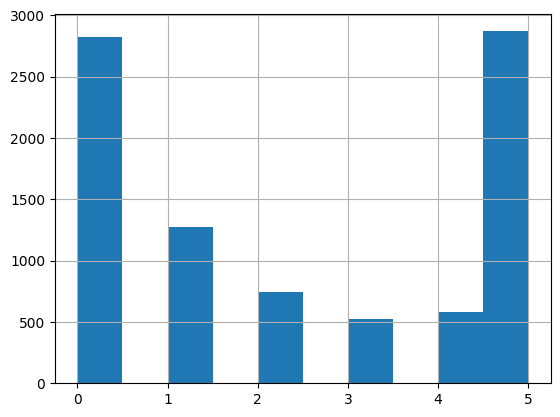

<Axes: >

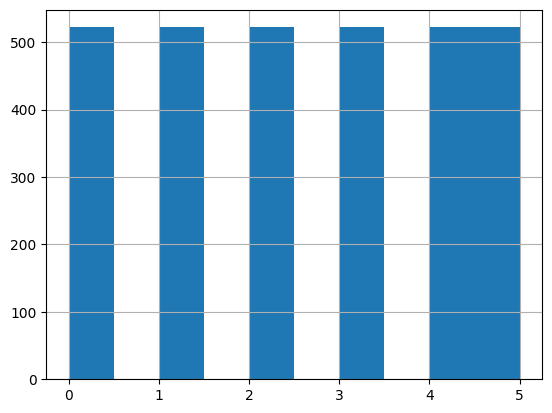

In [ ]:
df['memory_usage_label'].hist()

plt.show()

balanced_df['memory_usage_label'].hist()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin','activation_encoding_cos',
                        # 'Input Size (MB)', 'Forward/Backward Pass Size (MB)', 'Params Size (MB)', 'Estimated Total Size (MB)'
                        ]].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

total data size:  6516
train size 4561, val size: 1291, test size: 664


In [ ]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        # Store the input and target data
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        # Returns the total number of samples
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return a single sample (input, target pair)
        return self.inputs[idx], self.targets[idx]

train_dataloader = DataLoader(CustomDataset(x_train, y_train), 64, num_workers=2, shuffle=True)
val_dataloader = DataLoader(CustomDataset(x_val, y_val), 64, num_workers=2)
test_dataloader = DataLoader(CustomDataset(x_test, y_test),1, num_workers=1)
x, y = next(iter(train_dataloader))
print(f"input shape: {x.shape}, output shape: {y.shape}")

input shape: torch.Size([64, 9]), output shape: torch.Size([64])


In [ ]:
class FC_base(nn.Module):
    def __init__(self, input_features, output_features, base_features):
        super(FC_base, self).__init__()

        # Define the network architecture
        self.fc1 = nn.Linear(input_features, base_features)
        self.bn1 = nn.BatchNorm1d(base_features)
        self.fc2 = nn.Linear(base_features, base_features)
        self.bn2 = nn.BatchNorm1d(base_features)
        self.fc3 = nn.Linear(base_features, base_features)
        self.bn3 = nn.BatchNorm1d(base_features)
        self.fc4 = nn.Linear(base_features, base_features)
        self.bn4 = nn.BatchNorm1d(base_features)
        self.fc5 = nn.Linear(base_features, base_features)
        self.bn5 = nn.BatchNorm1d(base_features)
        # self.fc6 = nn.Linear(base_features//2, base_features//2)
        # self.bn6 = nn.BatchNorm1d(base_features//2)

        self.final = nn.Linear(base_features, output_features)
        # self.dropout = nn.Dropout(p=0.0)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.bn5(self.fc5(x)))
        # x = self.relu(self.bn6(self.fc6(x)))
        x = self.final(x)
        return x

In [ ]:
from pytorch_lightning import seed_everything

seed = 13  # Set your desired seed
seed_everything(seed, workers=True)
torch.use_deterministic_algorithms(False)


INFO:lightning_fabric.utilities.seed:Seed set to 13


In [ ]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=9, output_features=output_size, base_features=8)
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()
        self.output_size = output_size

        # Apply weight initialization
        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)  # Xavier uniform initialization
            if module.bias is not None:
                nn.init.zeros_(module.bias)  # Initialize bias to zeros


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        # Apply label smoothing to the target labels
        # smoothed_labels = smooth_labels(y, self.output_size, self.smoothing)

        # assert (y >= 0).all() and (y < self.output_size).all(), "Labels are out of bounds."


        logits = self.forward(x)
        loss = self.criterion(logits, y)

        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        self.log('train_acc', acc, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()

        # assert (y >= 0).all() and (y < self.output_size).all(), "Labels are out of bounds."

        logits = self.forward(x)
        loss = self.criterion(logits, y)
        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('val_loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, on_step=False, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.0001)


        return optimizer
        # # Use a scheduler that doesn't require setting the learning rate explicitly
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
        # return {
        #     'optimizer': optimizer,
        #     'lr_scheduler': {
        #         'scheduler': scheduler,
        #         'monitor': 'val_loss',
        #         'frequency': 1
        #     }
        # }
        # return optimizer

In [ ]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)
print(len(labels))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=True, mode='min')


classifier_model = classification_gpu_usage(output_size = len(labels)).to(device)

summary(classifier_model, input_size=(9,), device=device)

cuda
6
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              80
       BatchNorm1d-2                    [-1, 8]              16
              ReLU-3                    [-1, 8]               0
            Linear-4                    [-1, 8]              72
       BatchNorm1d-5                    [-1, 8]              16
              ReLU-6                    [-1, 8]               0
            Linear-7                    [-1, 8]              72
       BatchNorm1d-8                    [-1, 8]              16
              ReLU-9                    [-1, 8]               0
           Linear-10                    [-1, 8]              72
      BatchNorm1d-11                    [-1, 8]              16
             ReLU-12                    [-1, 8]               0
           Linear-13                    [-1, 8]              72
      BatchNorm1d-14            

In [ ]:

classifier_model.train()
trainer = pl.Trainer(
    max_epochs=200,
    callbacks=[early_stopping],
)

# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | FC_base          | 502    | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
502       Trainable params
0         Non-trainable params
502       Total params
0.002     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.610


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 1.527


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.483


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 1.415


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.369


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.322


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.296


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.268


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.233


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.216


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.214


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.188


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.173


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.172


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.135


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.125


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.118


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.106


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.090


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.089


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.072


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.057


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.053


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.046


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.040


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.037


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.030


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.022


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.016


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.007


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.003


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.989


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.980


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.972


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.958


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.950


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.940


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.940


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.924


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.914


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.912


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.899


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.894


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.882


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.865


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.858


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.851


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.838


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.834


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.833


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.826


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.809


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.808


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.801


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.795


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.774


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.763


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.751


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.747


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.732


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.724


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.702


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.682


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.681


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.680


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.675


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.657


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.648


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.646


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.646


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.624


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.608


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.607


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.582


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.580


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


In [ ]:
classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0])
        if test_data[1].item() != torch.argmax(pred, 1).item():
            print(f"prediction: {torch.softmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

prediction: tensor([[0.0066, 0.0290, 0.2308, 0.2842, 0.2971, 0.1523]]), ground truth: tensor([3.])
prediction: tensor([[0.0311, 0.1172, 0.3570, 0.2461, 0.1543, 0.0943]]), ground truth: tensor([3.])
prediction: tensor([[1.2157e-05, 1.8184e-04, 9.3500e-03, 6.5649e-02, 3.1667e-01, 6.0814e-01]]), ground truth: tensor([4.])
prediction: tensor([[1.2376e-05, 1.8420e-04, 9.4058e-03, 6.5851e-02, 3.1692e-01, 6.0763e-01]]), ground truth: tensor([4.])
prediction: tensor([[0.0034, 0.0155, 0.1788, 0.2751, 0.3571, 0.1701]]), ground truth: tensor([2.])
prediction: tensor([[0.2426, 0.3288, 0.2605, 0.0783, 0.0557, 0.0341]]), ground truth: tensor([0.])
prediction: tensor([[0.3520, 0.3592, 0.1865, 0.0456, 0.0352, 0.0215]]), ground truth: tensor([0.])
prediction: tensor([[0.1604, 0.2797, 0.3218, 0.1149, 0.0765, 0.0467]]), ground truth: tensor([1.])
prediction: tensor([[0.0232, 0.0940, 0.3421, 0.2627, 0.1739, 0.1041]]), ground truth: tensor([4.])
prediction: tensor([[0.3082, 0.3507, 0.2147, 0.0574, 0.0427, 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
def below_diagonal_sum_rate(confusion_matrix):
    # Convert to a numpy array for easier manipulation if not already
    confusion_matrix = np.array(confusion_matrix)

    # Sum the elements below the main diagonal (excluding the diagonal itself)
    below_diag_sum = np.sum(np.tril(confusion_matrix, k=-1))

    # Get the total number of data points
    total_data_points = np.sum(confusion_matrix)

    # Calculate the rate by dividing below-diagonal sum by total data points
    rate = below_diag_sum / total_data_points

    return rate

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("Below Diagonal Sum Rate: {:.4f}".format(below_diagonal_sum_rate(cm)))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.7410
Precision: 0.7826
Recall: 0.7410
F1-Score: 0.7298
Below Diagonal Sum Rate: 0.0256

Confusion Matrix:
[[121  18   3   0   0   0]
 [  4  25  61   0   0   0]
 [  0   0  34   2  10   1]
 [  0   0   7   9  34   3]
 [  0   0   1   0  28  23]
 [  3   0   0   0   2 275]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90       142
         1.0       0.58      0.28      0.38        90
         2.0       0.32      0.72      0.44        47
         3.0       0.82      0.17      0.28        53
         4.0       0.38      0.54      0.44        52
         5.0       0.91      0.98      0.95       280

    accuracy                           0.74       664
   macro avg       0.66      0.59      0.56       664
weighted avg       0.78      0.74      0.73       664



In [ ]:
from sklearn.manifold import TSNE

print(df.columns)

# Initialize the t-SNE model
tsne = TSNE(n_components=2, random_state=43)

# Fit and transform the features

# tsne_results = tsne.fit_transform(df[['all_activations', 'all_parameters', 'batch_size','total_activation_mul_batch_size', 'conv2d_layers','batch_norm2d_layer', 'dropout_layers']])
# tsne_results = tsne.fit_transform(df[['all_activations', 'all_parameters', 'batch_size','total_activation_mul_batch_size', 'conv2d_layers','batch_norm2d_layer']])

tsne_results = tsne.fit_transform(df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']])

Index(['Activation Function', 'Total Activations', 'Total Parameters',
       'Batch Size', 'Total_Activations_Batch_Size', 'Conv2d Count',
       'BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
       'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)',
       'activation_encoding_sin', 'activation_encoding_cos',
       'memory_usage_label'],
      dtype='object')


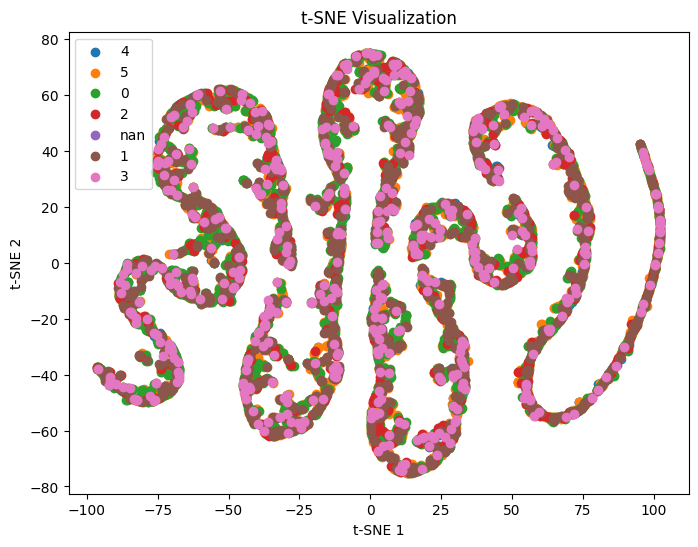

In [ ]:
import matplotlib.pyplot as plt

# Create a new DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['label'] = df['memory_usage_label']

# Plot the results
plt.figure(figsize=(8, 6))
for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['tsne1'], subset['tsne2'], label=label)

plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


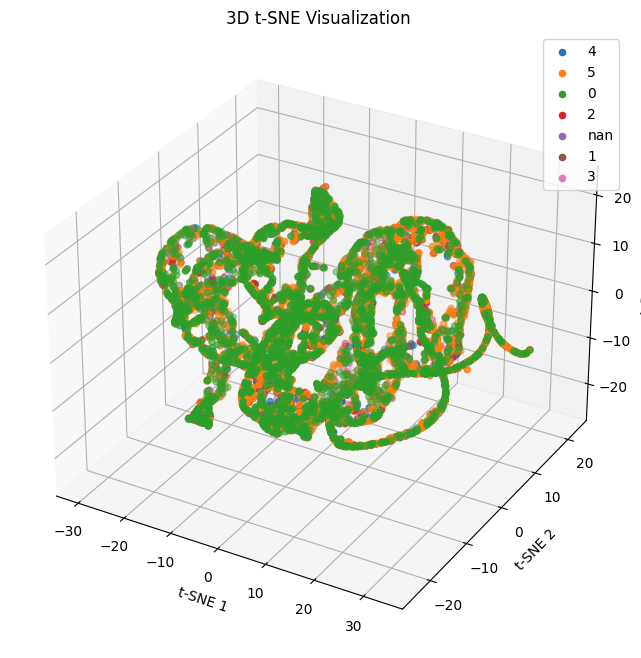

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Initialize the t-SNE model with 3 components
tsne = TSNE(n_components=3, random_state=43)


# Fit and transform the features

tsne_results = tsne.fit_transform(df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']])

# Create a new DataFrame for the t-SNE results (3 components)
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2', 'tsne3'])
tsne_df['label'] = df['memory_usage_label']

# Plot the results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    ax.scatter(subset['tsne1'], subset['tsne2'], subset['tsne3'], label=label)

# Set plot title and labels
ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')

# Add legend
plt.legend()

# Show the plot
plt.show()

# PCA

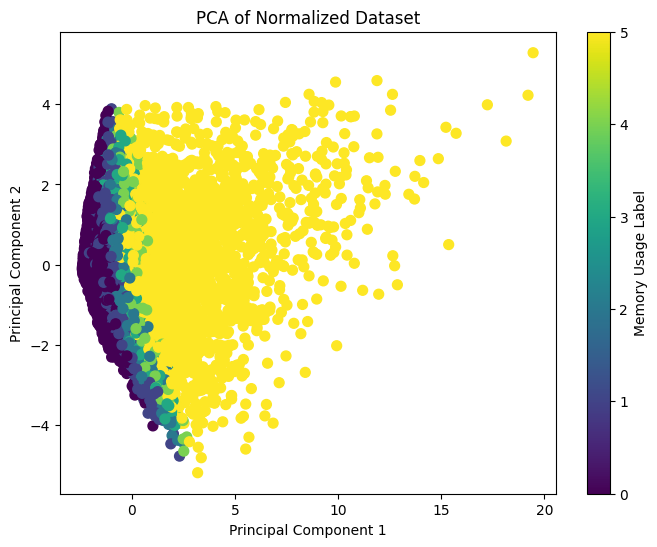

PCA Components:
[[ 0.39144525  0.33177347  0.09404917  0.41106402  0.19927543  0.12216711
   0.14356052  0.00836939 -0.00423015  0.18673217  0.41140642  0.33177348
   0.41151823]
 [-0.04793921 -0.33104858  0.47593333  0.16939498 -0.32891021 -0.21196278
  -0.18194756  0.01123321 -0.02451194  0.52504441  0.17443705 -0.33104857
   0.17397215]]
Explained variance ratio:
[0.40432253 0.14763565]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Import for normalization

X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar(label='Memory Usage Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Normalized Dataset')

# Show the plot
plt.show()

components = pca.components_

# Get the explained variance ratio for each component (optional, to know how much variance each component explains)
explained_variance = pca.explained_variance_ratio_

# Show the components (each row corresponds to a principal component, each column corresponds to the original feature)
print("PCA Components:")
print(components)

# Show the explained variance ratio for each component
print("Explained variance ratio:")
print(explained_variance)

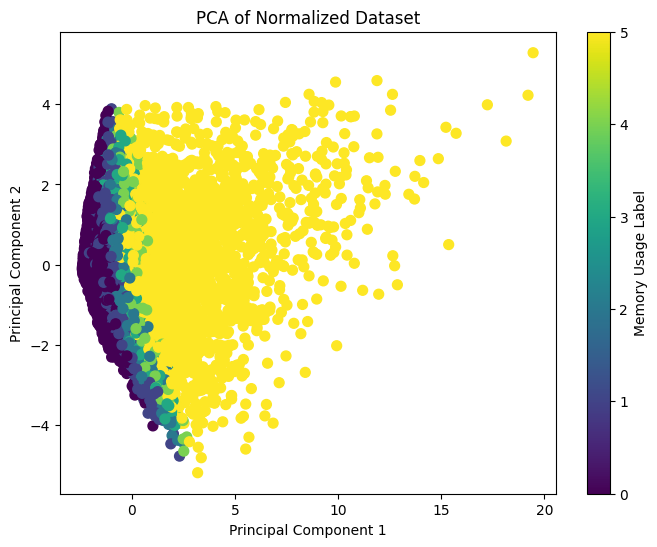

PCA Components:
[[ 0.39144525  0.33177347  0.09404917  0.41106402  0.19927543  0.12216711
   0.14356052  0.00836939 -0.00423015  0.18673217  0.41140642  0.33177348
   0.41151823]
 [-0.04793921 -0.33104858  0.47593333  0.16939498 -0.32891021 -0.21196278
  -0.18194756  0.01123321 -0.02451194  0.52504441  0.17443705 -0.33104857
   0.17397215]]
Explained variance ratio:
[0.40432253 0.14763565]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Import for normalization

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file


# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# X = df[['all_activations', 'all_parameters', 'batch_size', 'conv2d_layers','batch_norm2d_layer', 'dropout_layers']]  # Input features
X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar(label='Memory Usage Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Normalized Dataset')

# Show the plot
plt.show()

components = pca.components_

# Get the explained variance ratio for each component (optional, to know how much variance each component explains)
explained_variance = pca.explained_variance_ratio_

# Show the components (each row corresponds to a principal component, each column corresponds to the original feature)
print("PCA Components:")
print(components)

# Show the explained variance ratio for each component
print("Explained variance ratio:")
print(explained_variance)

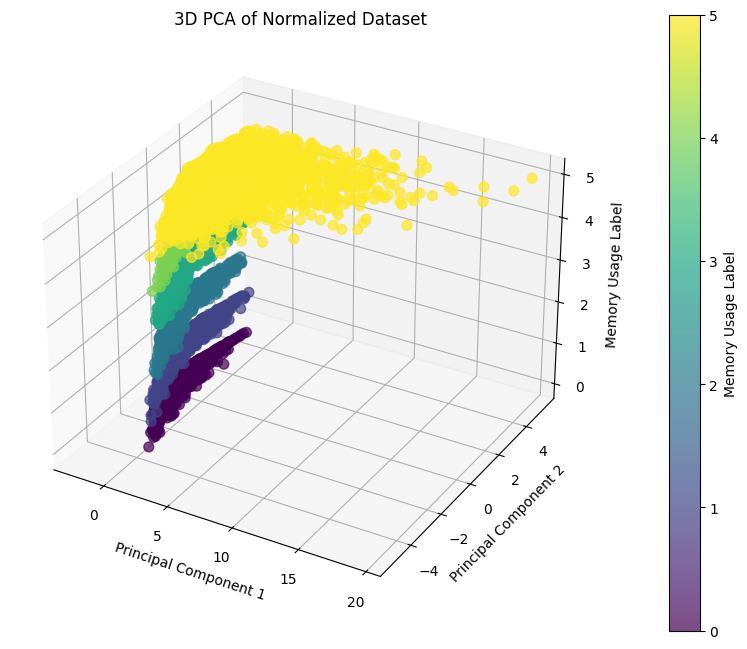

PCA Components:
[[ 0.39144525  0.33177347  0.09404917  0.41106402  0.19927543  0.12216711
   0.14356052  0.00836939 -0.00423015  0.18673217  0.41140642  0.33177348
   0.41151823]
 [-0.04793921 -0.33104858  0.47593333  0.16939498 -0.32891021 -0.21196278
  -0.18194756  0.01123321 -0.02451194  0.52504441  0.17443705 -0.33104857
   0.17397215]
 [-0.01413259  0.03887156  0.01546551 -0.02157242  0.00261678 -0.01210389
  -0.02161968  0.70533482 -0.70505233 -0.00450399 -0.02048151  0.03887162
  -0.02042515]]
Explained Variance Ratio:
[0.40432253 0.14763565 0.10040577]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=3)  # Change to 3 components for 3D plotting
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], y, c=y, cmap='viridis', s=50, alpha=0.7)

# Labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Memory Usage Label')
ax.set_title('3D PCA of Normalized Dataset')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Memory Usage Label')

# Show the plot
plt.show()

# Retrieve and display PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained Variance Ratio:")
print(explained_variance)


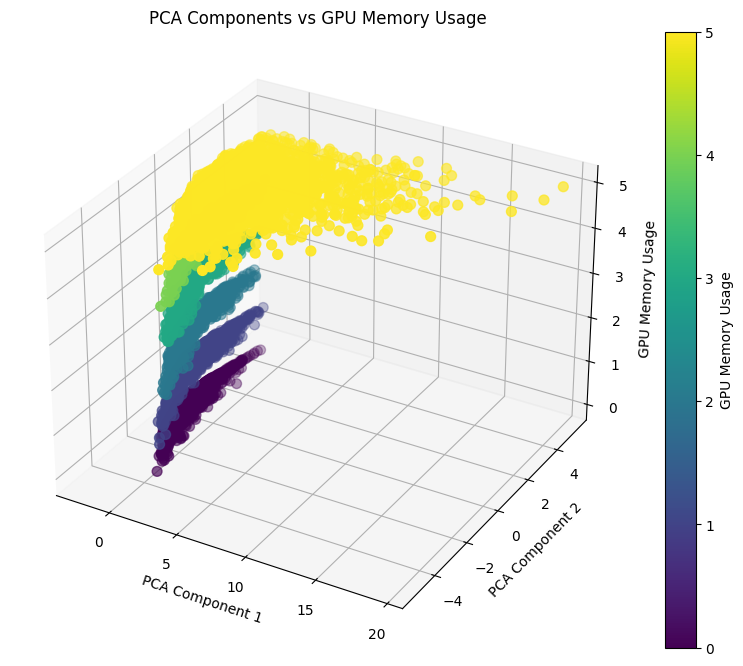

PCA Components:
[[ 0.39144525  0.33177347  0.09404917  0.41106402  0.19927543  0.12216711
   0.14356052  0.00836939 -0.00423015  0.18673217  0.41140642  0.33177348
   0.41151823]
 [-0.04793921 -0.33104858  0.47593333  0.16939498 -0.32891021 -0.21196278
  -0.18194756  0.01123321 -0.02451194  0.52504441  0.17443705 -0.33104857
   0.17397215]]
Explained variance ratio:
[0.40432253 0.14763565]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Prepare data
X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Actual GPU memory usage

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1 = X_pca[:, 0]
pca2 = X_pca[:, 1]

# Plotting the PCA-reduced data with GPU memory usage as z-axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(pca1, pca2, y, c=y, cmap='viridis', s=50)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('GPU Memory Usage')
ax.set_title('PCA Components vs GPU Memory Usage')

# Color bar
cbar = plt.colorbar(scatter, ax=ax, label='GPU Memory Usage')
plt.show()

# Output PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained variance ratio:")
print(explained_variance)


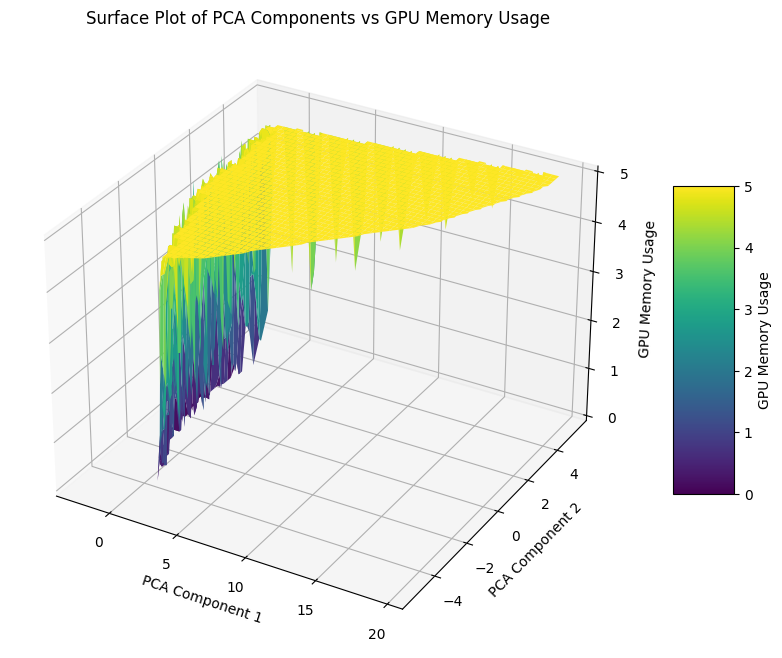

PCA Components:
[[ 0.39144525  0.33177347  0.09404917  0.41106402  0.19927543  0.12216711
   0.14356052  0.00836939 -0.00423015  0.18673217  0.41140642  0.33177348
   0.41151823]
 [-0.04793921 -0.33104858  0.47593333  0.16939498 -0.32891021 -0.21196278
  -0.18194756  0.01123321 -0.02451194  0.52504441  0.17443705 -0.33104857
   0.17397215]]
Explained variance ratio:
[0.40432253 0.14763565]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Prepare data
X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Actual GPU memory usage

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1 = X_pca[:, 0]
pca2 = X_pca[:, 1]

# Create grid for surface plot
pca1_grid, pca2_grid = np.meshgrid(np.linspace(pca1.min(), pca1.max(), 100),
                                   np.linspace(pca2.min(), pca2.max(), 100))

# Interpolate to fit the GPU memory usage on the grid
memory_usage_grid = griddata((pca1, pca2), y, (pca1_grid, pca2_grid), method='linear')

# Plotting the PCA-reduced data with GPU memory usage as a surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(pca1_grid, pca2_grid, memory_usage_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('GPU Memory Usage')
ax.set_title('Surface Plot of PCA Components vs GPU Memory Usage')

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('GPU Memory Usage')

plt.show()

# Output PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained variance ratio:")
print(explained_variance)

# regression model

In [ ]:
columns_to_normalize = ['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the data
df_normalized_reg = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)

# no normalization
# df_normalized = df

KeyError: "['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers'] not in index"

In [ ]:
from sklearn.model_selection import train_test_split
x_train_reg, x_temp_reg, y_train_reg, y_temp_reg = train_test_split(
    df_normalized_reg[['layers', 'batch_size', 'all_parameters', 'all_activations']].values, df_normalized_reg['real_memory_usage'].values, test_size=0.3, random_state=42)

x_test_reg, x_val_reg, y_test_reg, y_val_reg = train_test_split(
    x_temp_reg, y_temp_reg, test_size=0.66, random_state=42)

print('total data size: ', len(df_normalized))
print(f"train size {len(x_train_reg)}, val size: {len(x_val_reg)}, test size: {len(x_test_reg)}")

In [ ]:
train_dataloader_reg = DataLoader(CustomDataset(x_train_reg, y_train_reg), 64, num_workers=2, shuffle=True)
val_dataloader_reg = DataLoader(CustomDataset(x_val_reg, y_val_reg), 64, num_workers=2)
test_dataloader_reg = DataLoader(CustomDataset(x_test_reg, y_test_reg),1, num_workers=1)
x, y = next(iter(train_dataloader_reg))
print(f"input shape: {x.shape}, output shape: {y.shape}")

In [ ]:
class regression_gpu_usage(pl.LightningModule):
    def __init__(self):
        super(regression_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=4, output_features=1, base_features=4)
        # self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss()
        # self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        # y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        # y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = Adam(self.parameters(), lr=0.0001)

        # # Use a scheduler that doesn't require setting the learning rate explicitly
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        # return {
        #     'optimizer': optimizer,
        #     'lr_scheduler': {
        #         'scheduler': scheduler,
        #         'monitor': 'val_loss',
        #         'frequency': 1
        #     }
        # }
        return optimizer



In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
# logger = TensorBoardLogger("logs")
# Create a checkpoint callback

# checkpoint_callback = ModelCheckpoint(
#     dirpath=config['model_save_dir'],
#     filename=f"{config['modality_type']}",
#     save_top_k=1,
#     verbose=True,
#     monitor='val_loss',
#     mode='min'
# )

# Initialize the model
regression_model = regression_gpu_usage()
regression_model.train()
# Initialize the trainer with mixed precision (AMP) and early stopping
trainer = pl.Trainer(
    # logger = logger,
    max_epochs=200,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(regression_model, train_dataloaders=train_dataloader_reg, val_dataloaders=val_dataloader_reg)



In [ ]:
regression_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader_reg:
        pred = regression_model(test_data[0])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(pred.item())
        print(f"prediction: {pred.item()}, gt: {test_data[1].item()}")

plt.figure(figsize=(15, 3))
plt.scatter(range(1, len(pred_list) + 1), pred_list, label="predicted")
plt.scatter(range(1, len(gt) + 1), gt, label="actual value")
plt.legend()